In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

In [3]:
UNPROCESSED_DATASETS_PATH = 'unprocessed_datasets'
PROCESSED_DATASETS_PATH = 'processed_datasets'
SAMPLE_SIZE = len([name for name in os.listdir(UNPROCESSED_DATASETS_PATH) if os.path.isdir(os.path.join(UNPROCESSED_DATASETS_PATH, name))])

In [4]:
EXERCICES_TYPE = []
SENSORS_TYPE = {}

for root, dirs, files in os.walk(UNPROCESSED_DATASETS_PATH):
    for dir_name in dirs:
        if not dir_name.isdigit() and dir_name not in EXERCICES_TYPE:
            EXERCICES_TYPE.append(dir_name)          

    for file_name in files:
        if file_name.split('_')[0] not in SENSORS_TYPE:
            match file_name.split('_')[0]:
                case 'emg':
                    SENSORS_TYPE['emg'] = 2000
                case 'imu':
                    SENSORS_TYPE['imu'] = 100
                case 'ips':
                    SENSORS_TYPE['ips'] = 60
                case 'cop':
                    SENSORS_TYPE['cop'] = 60
                case 'mocap':
                    SENSORS_TYPE['mocap'] = 100
            
            

print("\nEXERCICES_TYPE :")
print(EXERCICES_TYPE)

print("\nSENSORS_TYPE :")
print(SENSORS_TYPE)


EXERCICES_TYPE :
['back', 'forward', 'halfsquat', 'still']

SENSORS_TYPE :
{'cop': 60, 'emg': 2000, 'imu': 100, 'ips': 60, 'mocap': 100}


In [5]:
def save_to_csv(df, output_dir):
        os.makedirs(os.path.dirname(output_dir), exist_ok=True)
        df.to_csv(output_dir, index=False)

def process_data(input_file):
        data = pd.read_csv(input_file)
        non_numeric_keys = [key for key in data.keys() if not (isinstance(key, (int, float)) or key.isdigit())]
        data = data.rename(columns={non_numeric_keys[0]: 'ID'})
        data = data.set_index('ID').transpose()
        return data

def existing_directory(output_dir):
    if os.path.exists(output_dir):
        print(f"File {output_dir} already exists")
        return True
    return False

In [6]:
def resampling(dataset_wrong_frequency,dataset_desired_frequency,wrong_frequency,desired_frequency):
    if wrong_frequency == desired_frequency:
        return dataset_wrong_frequency
    
    df_wrong_Hz = dataset_wrong_frequency
    sampling_rate_wrong_Hz = wrong_frequency
    df_wrong_Hz['time'] =  pd.date_range(start='00:00:00', periods=df_wrong_Hz.shape[0], freq=f'{int(1e6 / sampling_rate_wrong_Hz)}us')

    n_points_wrong_Hz = len(df_wrong_Hz)
    n_points_desired_Hz = dataset_desired_frequency.shape[0]
    print(n_points_desired_Hz)

    time = pd.date_range(start=df_wrong_Hz['time'].iloc[0],periods=n_points_desired_Hz,freq=f'{int(desired_frequency/10)}ms')
    df_wrong_Hz.set_index('time', inplace=True)
    df_wrong_Hz_resampled = df_wrong_Hz.reindex(time).interpolate(method='linear')
    
    # Affichage des résultats
    print(f"Nombre de points à {wrong_frequency} Hz avant interpolation:", n_points_wrong_Hz)
    print(f"Nombre de points à {desired_frequency}  Hz après interpolation:", len(df_wrong_Hz_resampled))
    return df_wrong_Hz_resampled

In [13]:
def combine_and_harmonize(sensor,sensor_rate,correct_rate):
    df = pd.DataFrame()
    
    for exercice in EXERCICES_TYPE:
        for i in range(1, SAMPLE_SIZE):
            try:
                input_file = f'{UNPROCESSED_DATASETS_PATH}/{i}/{exercice}/{sensor}_1.csv'
                correct_sampling = process_data(f"{UNPROCESSED_DATASETS_PATH}/{i}/{exercice}/cop_1.csv")
                print(f'Reading {input_file}')
                processed_data = resampling(process_data(input_file),correct_sampling,sensor_rate,correct_rate)
                processed_data['label'] = exercice
                df = pd.concat([df, processed_data], axis=0).reset_index(drop=True)
            except Exception as e:
                print(f"Error processing file {input_file}: {e}")
                continue
    return df

In [14]:
for sensor_type,sensor_frequency in SENSORS_TYPE.items():
    output_dir = f"{PROCESSED_DATASETS_PATH}/unbalanced/{sensor_type}.csv"
    print(f"Saving {sensor_type} to output_dir")
    save_to_csv(combine_and_harmonize(f'{sensor_type}',sensor_frequency,60), output_dir)

Saving cop to output_dir
Reading unprocessed_datasets/1/back/cop_1.csv
Reading unprocessed_datasets/2/back/cop_1.csv
Reading unprocessed_datasets/3/back/cop_1.csv
Reading unprocessed_datasets/4/back/cop_1.csv
Reading unprocessed_datasets/5/back/cop_1.csv
Reading unprocessed_datasets/6/back/cop_1.csv
Reading unprocessed_datasets/7/back/cop_1.csv
Reading unprocessed_datasets/8/back/cop_1.csv
Reading unprocessed_datasets/9/back/cop_1.csv
Reading unprocessed_datasets/10/back/cop_1.csv
Reading unprocessed_datasets/11/back/cop_1.csv
Reading unprocessed_datasets/12/back/cop_1.csv
Reading unprocessed_datasets/13/back/cop_1.csv
Reading unprocessed_datasets/14/back/cop_1.csv
Reading unprocessed_datasets/15/back/cop_1.csv
Reading unprocessed_datasets/16/back/cop_1.csv
Reading unprocessed_datasets/17/back/cop_1.csv
Reading unprocessed_datasets/18/back/cop_1.csv
Reading unprocessed_datasets/19/back/cop_1.csv
Reading unprocessed_datasets/20/back/cop_1.csv
Reading unprocessed_datasets/21/back/cop_1.c

In [51]:
number_of_measures = pd.DataFrame(columns=EXERCICES_TYPE, index=SENSORS_TYPE)
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        data = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/{sensor}.csv")
        number_of_measures.loc[sensor,exercice] = data[data['label'] == exercice].shape[0]

In [31]:
number_of_measures

,back,forward,halfsquat,still
cop,86658,72832,80314,83333
emg,86658,72832,80314,83333
imu,86658,72832,80314,83333
ips,91072,75028,84441,83333
mocap,86658,72832,80314,83333


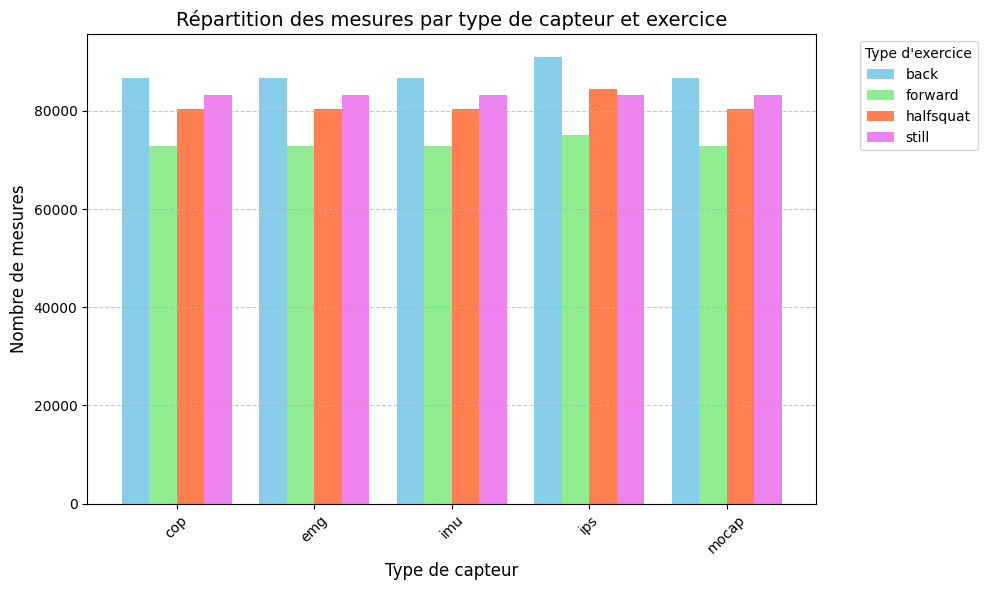

In [49]:
# Plot settings
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting grouped bars
number_of_measures.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'lightgreen', 'coral', 'violet', 'gold'])

# Customize axes
ax.set_xlabel("Type de capteur", fontsize=12)
ax.set_ylabel("Nombre de mesures", fontsize=12)
ax.set_title("Répartition des mesures par type de capteur et exercice", fontsize=14)
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x', rotation=45)

# Add legend
ax.legend(title="Type d'exercice", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

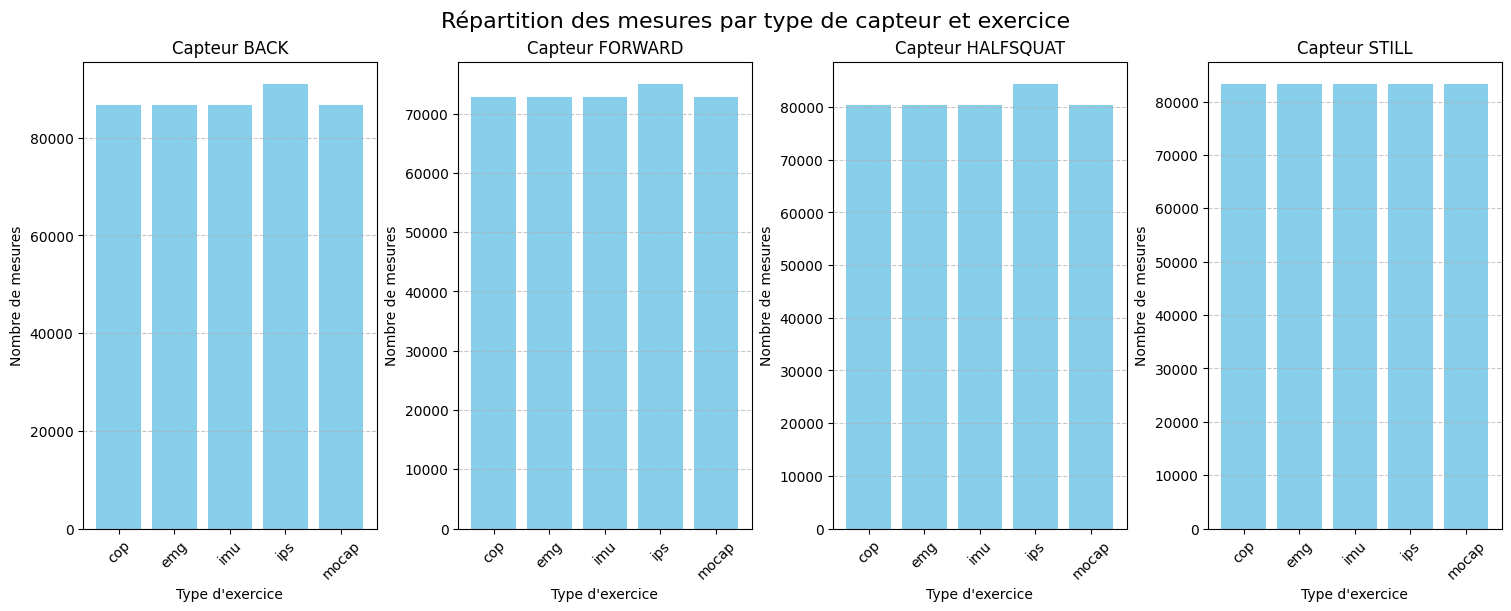

In [50]:
# Nombre de types de capteurs
num_sensors = len(number_of_measures.columns)
fig, axs = plt.subplots(1, num_sensors, figsize=(15, 6), constrained_layout=True)

# Visualisation pour chaque capteur
for i, sensor in enumerate(number_of_measures.columns):
    axs[i].bar(number_of_measures.index, number_of_measures[sensor], color='skyblue')
    axs[i].set_xlabel("Type d'exercice", fontsize=10)
    axs[i].set_ylabel("Nombre de mesures", fontsize=10)
    axs[i].set_title(f"Capteur {sensor.upper()}", fontsize=12)
    axs[i].tick_params(axis='x', rotation=45)  # Rotation des labels de l'axe x pour plus de lisibilité
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille sur l'axe y

# Titre global pour la figure
fig.suptitle("Répartition des mesures par type de capteur et exercice", fontsize=16)
plt.show()

In [19]:
rus = RandomUnderSampler(random_state=42)

for sensor in SENSORS_TYPE:
    combined_df = pd.DataFrame()
    for exercice in EXERCICES_TYPE:
        output_dir = f"{PROCESSED_DATASETS_PATH}/balanced/{exercice}/{sensor}.csv"
        if existing_directory(output_dir):
            continue 
        print(f"Reading {exercice}/{sensor}.csv")
        df = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/{exercice}/{sensor}.csv")  # Replace with the actual path
        df['label'] = exercice
        # Combine the datasets
        combined_df = pd.concat([df, combined_df], ignore_index=True)
    
    if existing_directory(output_dir) == False:
        combined_df.dropna(inplace=True)
        # Separate features and labels
        X = combined_df.drop(columns=['label'])  # Features
        y = combined_df['label']  # Labels

        X_resampled, y_resampled = rus.fit_resample(X, y)

        # Apply UnderSampler to balance the classes
        print(f"Applying UnderSampler to {sensor}.csv")
        print(X.shape, y.shape)
        X_resampled, y_resampled = rus.fit_resample(X, y)
        print(f"Applied")
        print(X_resampled.shape, y_resampled.shape)

        # Combine the resampled features and labels into a new DataFrame
        balanced_df = pd.DataFrame(X_resampled, columns=X.columns)
        balanced_df['label'] = y_resampled

        for exercice_type in EXERCICES_TYPE:
            output_dir = f"{PROCESSED_DATASETS_PATH}/balanced/{exercice_type}/{sensor}.csv"
            save_to_csv(balanced_df[balanced_df['label'] == exercice_type], output_dir)
            print(f"Saved {exercice_type} to {sensor}.csv")

Reading back/cop.csv
Reading forward/cop.csv
Reading halfsquat/cop.csv
Reading still/cop.csv
Applying UnderSampler to cop.csv
(314942, 10) (314942,)
Applied
(288476, 10) (288476,)
Saved back to cop.csv
Saved forward to cop.csv
Saved halfsquat to cop.csv
Saved still to cop.csv
Reading back/emg.csv
Reading forward/emg.csv
Reading halfsquat/emg.csv
Reading still/emg.csv
Applying UnderSampler to emg.csv
(10772128, 16) (10772128,)
Applied
(9712004, 16) (9712004,)
Saved back to emg.csv
Saved forward to emg.csv
Saved halfsquat to emg.csv
Saved still to emg.csv
Reading back/imu.csv
Reading forward/imu.csv
Reading halfsquat/imu.csv
Reading still/imu.csv
Applying UnderSampler to imu.csv
(538613, 54) (538613,)
Applied
(485604, 54) (485604,)
Saved back to imu.csv
Saved forward to imu.csv
Saved halfsquat to imu.csv
Saved still to imu.csv
Reading back/ips.csv
Reading forward/ips.csv
Reading halfsquat/ips.csv
Reading still/ips.csv
Applying UnderSampler to ips.csv
(333874, 682) (333874,)
Applied
(3001

C:\Users\floda\AppData\Local\Temp\ipykernel_10704\2970153407.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  balanced_df['label'] = y_resampled


Saved back to ips.csv
Saved forward to ips.csv
Saved halfsquat to ips.csv
Saved still to ips.csv
Reading back/mocap.csv
Reading forward/mocap.csv
Reading halfsquat/mocap.csv
Reading still/mocap.csv
Applying UnderSampler to mocap.csv
(538613, 78) (538613,)
Applied
(485604, 78) (485604,)
Saved back to mocap.csv
Saved forward to mocap.csv
Saved halfsquat to mocap.csv
Saved still to mocap.csv


In [20]:
number_of_measures = pd.DataFrame(columns=SENSORS_TYPE, index=EXERCICES_TYPE)
for exercice in EXERCICES_TYPE:
    for sensor in SENSORS_TYPE:
        number_of_measures.loc[exercice, sensor] = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/balanced/{exercice}/{sensor}.csv").shape[0]

In [21]:
for sensor in SENSORS_TYPE:
    output_dir = f"{PROCESSED_DATASETS_PATH}/balanced/combined/{sensor}.csv"
    if existing_directory(output_dir) == False:
        combined_df = pd.DataFrame()
        for exercice in EXERCICES_TYPE: 
            print(f"Reading {exercice}/{sensor}.csv")
            df = pd.read_csv(f"{PROCESSED_DATASETS_PATH}/unbalanced/{exercice}/{sensor}.csv")  # Replace with the actual path
            df['label'] = exercice
            # Combine the datasets
            combined_df = pd.concat([df, combined_df], ignore_index=True)
        print(combined_df.head())
        save_to_csv(combined_df, output_dir)


Reading back/cop.csv
Reading forward/cop.csv
Reading halfsquat/cop.csv
Reading still/cop.csv
      L_force     R_force   L_cop_x   L_cop_y   R_cop_x   R_cop_y  L_cop_col  \
0  379.888230  382.717709 -0.034578  0.208298 -0.024375 -0.118024       6.92   
1  381.004205  382.717709 -0.034726  0.208249 -0.024538 -0.117956       6.91   
2  380.736195  382.717709 -0.034947  0.208284 -0.024698 -0.117885       6.92   
3  381.584160  381.821414 -0.035432  0.207988 -0.024785 -0.117850       6.93   
4  380.450611  381.821414 -0.035850  0.207939 -0.024996 -0.117710       6.95   

   L_cop_row  R_cop_col  R_cop_row  label  
0      16.66       6.87      15.31  still  
1      16.68       6.88      15.33  still  
2      16.73       6.88      15.35  still  
3      16.77       6.88      15.36  still  
4      16.85       6.88      15.39  still  
Reading back/emg.csv
Reading forward/emg.csv
Reading halfsquat/emg.csv
Reading still/emg.csv
     R_Vlat      R_RF      R_ST      R_TA    L_Vlat      L_RF      L_

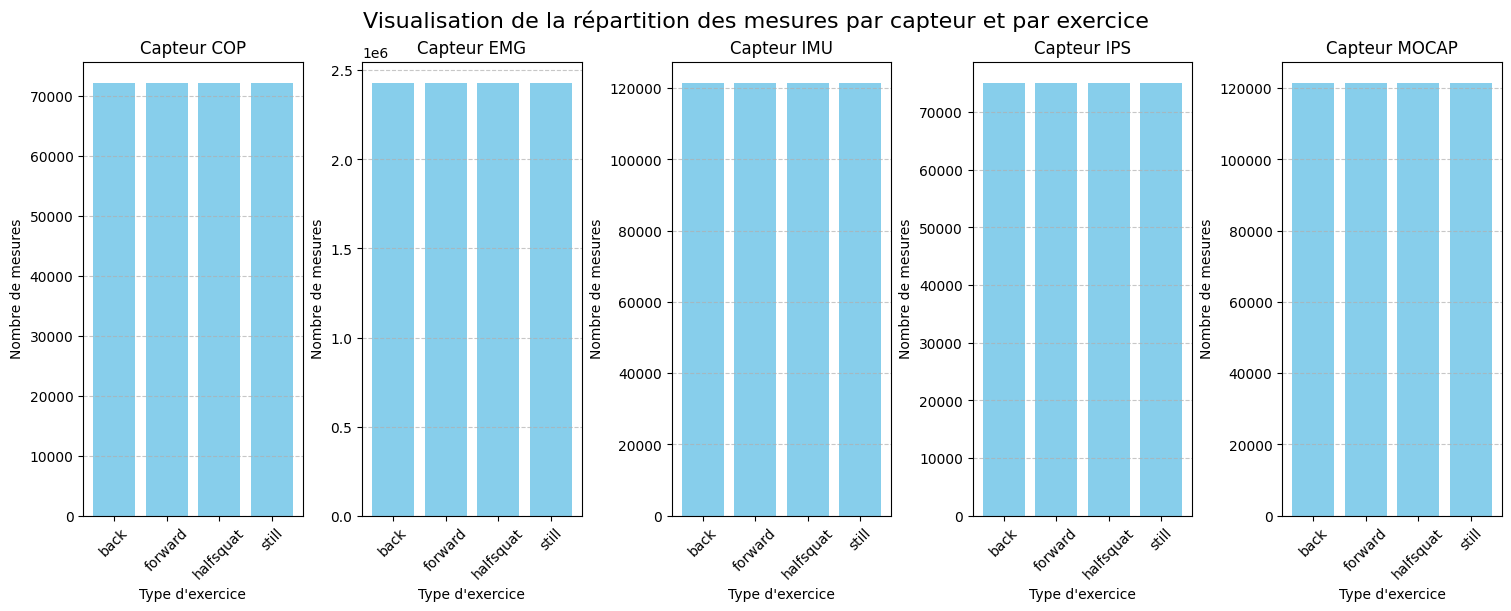

In [22]:
# Paramètres pour définir le nombre de colonnes en fonction du nombre de capteurs
num_sensors = len(SENSORS_TYPE)
fig, axs = plt.subplots(1, num_sensors, figsize=(15, 6), constrained_layout=True)

for i, sensor in enumerate(SENSORS_TYPE):
    # Visualisation de la répartition des classes pour chaque capteur
    axs[i].bar(EXERCICES_TYPE, number_of_measures[sensor], color='skyblue')
    axs[i].set_xlabel("Type d'exercice")
    axs[i].set_ylabel("Nombre de mesures")
    axs[i].set_title(f"Capteur {sensor.upper()}", fontsize=12)
    axs[i].tick_params(axis='x', rotation=45)  # Rotation des labels de l'axe x pour plus de lisibilité
    axs[i].grid(axis='y', linestyle='--', alpha=0.7)  # Ajout d'une grille sur l'axe y

# Titre global pour la figure
fig.suptitle("Visualisation de la répartition des mesures par capteur et par exercice", fontsize=16)
plt.show()